In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit

## 2D

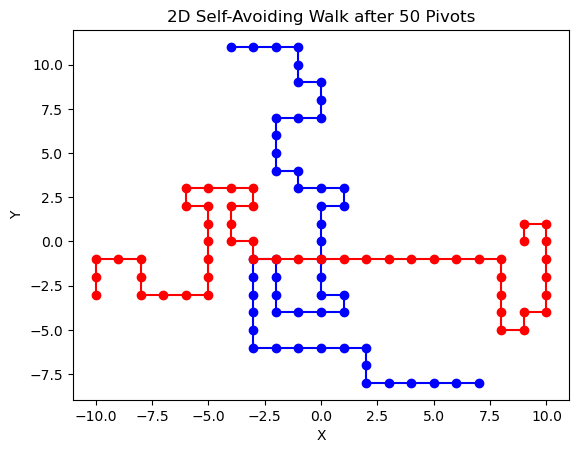

In [2]:
# Define a dot product function used for the rotate operation
def v_dot(a):
    return lambda b: np.dot(a, b)

class LatticeSAW2D:
    def __init__(self, N, l0):
        self.N = N
        self.l0 = l0
        # Initial configuration: a straight line in 2D
        self.init_state = np.stack((np.arange(N+1), np.zeros(N+1)), axis=-1)
        self.state = self.init_state.copy()

        # Integer rotation matrices for 90, 180, and 270 degree rotations
        self.rotate_matrix = np.array([
            [[0, -1], [1, 0]],   # 90 degrees
            [[-1, 0], [0, -1]],  # 180 degrees
            [[0, 1], [-1, 0]]    # 270 degrees
        ])
        
    # Define pivot algorithm process where t is the number of successful steps
    def walk(self, t):
        acpt = 0
        # While loop until the number of successful steps reaches t
        while acpt < t:
            pick_pivot = np.random.randint(1, self.N)  # Pick a pivot site
            pick_side = np.random.choice([-1, 1])  # Pick a side
            
            if pick_side == 1:
                old_chain = self.state[:pick_pivot + 1]
                temp_chain = self.state[pick_pivot + 1:]
            else:
                old_chain = self.state[pick_pivot:]
                temp_chain = self.state[:pick_pivot]
            
            # Pick a symmetry operator
            symtry_oprtr = self.rotate_matrix[np.random.randint(len(self.rotate_matrix))]
            # New chain after symmetry operator
            new_chain = np.apply_along_axis(v_dot(symtry_oprtr), 1, temp_chain - self.state[pick_pivot]) + self.state[pick_pivot]

            # Ensure the new chain has integer values
            new_chain = np.rint(new_chain).astype(int)

            # Use cdist function of scipy package to calculate the pair-pair distance between old_chain and new_chain
            overlap = cdist(new_chain, old_chain)
            overlap = overlap.flatten()
            
            # Determine whether the new state is accepted or rejected
            if len(np.nonzero(overlap)[0]) != len(overlap):
                continue  # Reject the move if overlapping
            else:
                if pick_side == 1:
                    self.state = np.concatenate((old_chain, new_chain), axis=0)
                elif pick_side == -1:
                    self.state = np.concatenate((new_chain, old_chain), axis=0)
                acpt += 1
        
        # Center the chain at the origin using integer arithmetic
        center_of_mass = np.mean(self.state, axis=0).astype(int)
        self.state = self.state - center_of_mass

    # Shift the chain to the origin based on the first endpoint
    def shift_to_origin(self, chain):
        first_endpoint = chain[0]
        return chain - first_endpoint

    # Shift the chain so that the first endpoint is at (0, 1)
    def shift_to_origin_plus_one(self, chain):
        first_endpoint = chain[0]
        return chain - first_endpoint + np.array([0, 1])
    
# Parameters
N = 50  # Number of monomers (number of steps)
l0 = 1  # Bond length (step length)
t = 50  # Number of pivot steps to perform

# Create an instance of the LatticeSAW2D class
chain = LatticeSAW2D(N, l0)
# Perform the walk
chain.walk(t)

chain2 = LatticeSAW2D(N, l0)
chain2.walk(t)

# Plot the walk after t pivots
plt.plot(chain.state[:, 0], chain.state[:, 1], 'bo-')
plt.plot(chain2.state[:, 0], chain2.state[:, 1], 'ro-')
plt.title(f'2D Self-Avoiding Walk after {t} Pivots')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Text(0.5, 0, 'X')

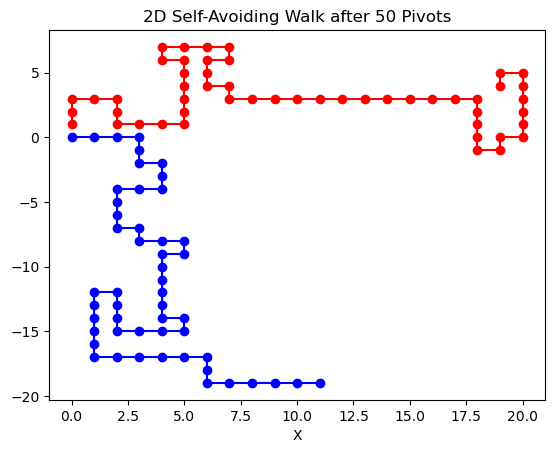

In [3]:
# shift the first chain to the origin
chain.state = chain.shift_to_origin(chain.state)

# shift the second chain to the origin
chain2.state = chain2.shift_to_origin_plus_one(chain2.state)

# Plot the walk after t pivots
plt.plot(chain.state[:, 0], chain.state[:, 1], 'bo-')
plt.plot(chain2.state[:, 0], chain2.state[:, 1], 'ro-')
plt.title(f'2D Self-Avoiding Walk after {t} Pivots')
plt.xlabel('X')



In [4]:
# find the distance between two chains using cdist
distance = cdist(chain.state, chain2.state)
distance = distance.flatten()

In [5]:
len(np.nonzero(distance)[0]) == len(distance)

True

In [23]:
N = 199
l0 = 1
t = 200
n_walks = 1000

B_n_counter = 0
for i in range(n_walks):
    chain1 = LatticeSAW2D(N, l0)
    chain.walk(t)
    chain2 = LatticeSAW2D(N, l0)
    chain2.walk(t)

    chain1.state = chain1.shift_to_origin(chain1.state)
    chain2.state = chain2.shift_to_origin_plus_one(chain2.state)

    distance = cdist(chain1.state, chain2.state)
    distance = distance.flatten()

    if len(np.nonzero(distance)[0]) == len(distance):
        B_n_counter += 1

In [24]:
num_24 = 17266613812
B_n_ave = B_n_counter / n_walks
B_n_ave *= 4
B_n_ave

1.3

In [20]:
c_49 = B_n_ave * num_24 ** 2
c_49

4.746324364321367e+20

## 3d

In [25]:
import numpy as np
import timeit
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Define a dot product function used for the rotate operation
def v_dot(a):
    return lambda b: np.dot(a, b)

class lattice_SAW:
    def __init__(self, N, l0):
        self.N = N
        self.l0 = l0
        # Initial configuration. Usually, we just use a straight chain as initial configuration
        self.init_state = np.dstack((np.arange(N), np.zeros(N), np.zeros(N)))[0]
        self.state = self.init_state.copy()
        
        # Define a rotation matrix
        # 9 possible rotations: 3 axes * 3 possible rotation angles (90, 180, 270)
        self.rotate_matrix = np.array([
            [[1,0,0], [0,0,-1], [0,1,0]], [[1,0,0], [0,-1,0], [0,0,-1]], [[1,0,0], [0,0,1], [0,-1,0]],
            [[0,0,1], [0,1,0], [-1,0,0]], [[-1,0,0], [0,1,0], [0,0,-1]], [[0,0,-1], [0,1,0], [-1,0,0]],
            [[0,-1,0], [1,0,0], [0,0,1]], [[-1,0,0], [0,-1,0], [0,0,1]], [[0,1,0], [-1,0,0], [0,0,1]]
        ])
        
    # Define pivot algorithm process where t is the number of successful steps
    def walk(self, t):
        acpt = 0
        # While loop until the number of successful steps reaches t
        while acpt < t:
            pick_pivot = np.random.randint(1, self.N - 1)  # Pick a pivot site
            pick_side = np.random.choice([-1, 1])  # Pick a side
            
            if pick_side == 1:
                old_chain = self.state[0:pick_pivot + 1]
                temp_chain = self.state[pick_pivot + 1:]
            else:
                old_chain = self.state[pick_pivot:]
                temp_chain = self.state[0:pick_pivot]
            
            # Pick a symmetry operator
            symtry_oprtr = self.rotate_matrix[np.random.randint(len(self.rotate_matrix))]
            # New chain after symmetry operator
            new_chain = np.apply_along_axis(v_dot(symtry_oprtr), 1, temp_chain - self.state[pick_pivot]) + self.state[pick_pivot]

            # Use cdist function of scipy package to calculate the pair-pair distance between old_chain and new_chain
            overlap = cdist(new_chain, old_chain)
            overlap = overlap.flatten()
            
            # Determine whether the new state is accepted or rejected
            if len(np.nonzero(overlap)[0]) != len(overlap):
                continue
            else:
                if pick_side == 1:
                    self.state = np.concatenate((old_chain, new_chain), axis=0)
                elif pick_side == -1:
                    self.state = np.concatenate((new_chain, old_chain), axis=0)
                acpt += 1
        
        # Place the center of mass of the chain on the origin
        self.state = self.l0 * (self.state - np.int_(np.mean(self.state, axis=0)))

    # Shift the chain to the origin based on the first endpoint
    def shift_to_origin(self, chain):
        first_endpoint = chain[0]
        return chain - first_endpoint

    # Shift the chain so that the first endpoint is at (0, 0, 1)
    def shift_to_origin_plus_one(self, chain):
        first_endpoint = chain[0]
        return chain - first_endpoint + np.array([0, 0, 1])


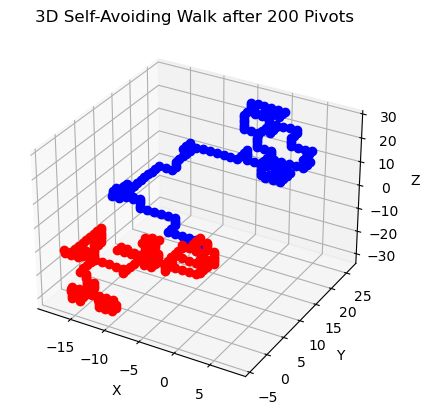

In [26]:
# make 2 3d lattices
chain1 = lattice_SAW(N, l0)
chain1.walk(t)

chain2 = lattice_SAW(N, l0)
chain2.walk(t)

# shift the first chain to the origin
chain1.state = chain1.shift_to_origin(chain1.state)

# shift the second chain to the origin
chain2.state = chain2.shift_to_origin_plus_one(chain2.state)

# Plot the walk after t pivots
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(chain1.state[:, 0], chain1.state[:, 1], chain1.state[:, 2], 'bo-')
ax.plot(chain2.state[:, 0], chain2.state[:, 1], chain2.state[:, 2], 'ro-')
ax.set_title(f'3D Self-Avoiding Walk after {t} Pivots')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [27]:
# find the distance between two chains using cdist
distance = cdist(chain1.state, chain2.state)
distance = distance.flatten()

len(np.nonzero(distance)[0]) == len(distance)

False

In [31]:
# Parameters for estimation
N = 127  # Number of monomers (number of steps)
l0 = 1   # Bond length (step length)
t = 150  # Number of pivot steps to perform
num_samples = 500  # Number of samples to estimate B_N

# Initialize the counter for B_N
B_n_counter = 0

# Loop over the number of samples
for i in range(num_samples):
    # Create an instance of the lattice_SAW class
    chain1 = lattice_SAW(N, l0)
    chain1.walk(t)
    
    chain2 = lattice_SAW(N, l0)
    chain2.walk(t)

    # Shift the first chain to the origin
    chain1.state = chain1.shift_to_origin(chain1.state)
    # Shift the second chain to the origin
    chain2.state = chain2.shift_to_origin_plus_one(chain2.state)

    # Calculate the distance between two chains using cdist
    distance = cdist(chain1.state, chain2.state)
    distance = distance.flatten()

    # Check if the two chains are non-overlapping
    if len(np.nonzero(distance)[0]) == len(distance):
        B_n_counter += 1
    
# Calculate the average value of B_N
B_n_ave = B_n_counter / num_samples
B_n_ave *= 6
B_n_ave

2.712

## 4d

In [33]:
import numpy as np
import timeit
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define a dot product function used for the rotation operation
def v_dot(a):
    return lambda b: np.dot(a, b)

class LatticeSAW4D:
    def __init__(self, N, l0):
        self.N = N
        self.l0 = l0
        # Initial configuration: a straight line in 4D
        self.init_state = np.dstack((np.arange(N), np.zeros(N), np.zeros(N), np.zeros(N)))[0]
        self.state = self.init_state.copy()
        
        # Define 4D rotation matrices for 90° rotations
        self.rotation_matrices = [
            np.array([[0, -1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]),  # xy-plane
            np.array([[0, 0, -1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1]]),  # xz-plane
            np.array([[0, 0, 0, -1], [0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0]]),  # xw-plane
            np.array([[1, 0, 0, 0], [0, 0, -1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]),  # yz-plane
            np.array([[1, 0, 0, 0], [0, 0, 0, -1], [0, 0, 1, 0], [0, 1, 0, 0]]),  # yw-plane
            np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, -1], [0, 0, 1, 0]])   # zw-plane
        ]
        
    # Define pivot algorithm process where t is the number of successful steps
    def walk(self, t):
        acpt = 0
        # While loop until the number of successful steps reaches t
        while acpt < t:
            pick_pivot = np.random.randint(1, self.N - 1)  # Pick a pivot site
            pick_side = np.random.choice([-1, 1])  # Pick a side
            
            if pick_side == 1:
                old_chain = self.state[0:pick_pivot + 1]
                temp_chain = self.state[pick_pivot + 1:]
            else:
                old_chain = self.state[pick_pivot:]
                temp_chain = self.state[0:pick_pivot]
            
            # Pick a rotation matrix
            rotation_matrix = self.rotation_matrices[np.random.randint(len(self.rotation_matrices))]
            # New chain after rotation
            new_chain = np.apply_along_axis(v_dot(rotation_matrix), 1, temp_chain - self.state[pick_pivot]) + self.state[pick_pivot]

            # Use cdist function of scipy package to calculate the pair-pair distance between old_chain and new_chain
            overlap = cdist(new_chain, old_chain)
            overlap = overlap.flatten()
            
            # Determine whether the new state is accepted or rejected
            if len(np.nonzero(overlap)[0]) != len(overlap):
                continue
            else:
                if pick_side == 1:
                    self.state = np.concatenate((old_chain, new_chain), axis=0)
                elif pick_side == -1:
                    self.state = np.concatenate((new_chain, old_chain), axis=0)
                acpt += 1
        
        # Place the center of mass of the chain on the origin
        self.state = self.l0 * (self.state - np.mean(self.state, axis=0))

    # Shift the chain to the origin based on the first endpoint
    def shift_to_origin(self, chain):
        first_endpoint = chain[0]
        return chain - first_endpoint

    # Shift the chain so that the first endpoint is at (0, 0, 0, 1)
    def shift_to_origin_plus_one(self, chain):
        first_endpoint = chain[0]
        return chain - first_endpoint + np.array([0, 0, 0, 1])


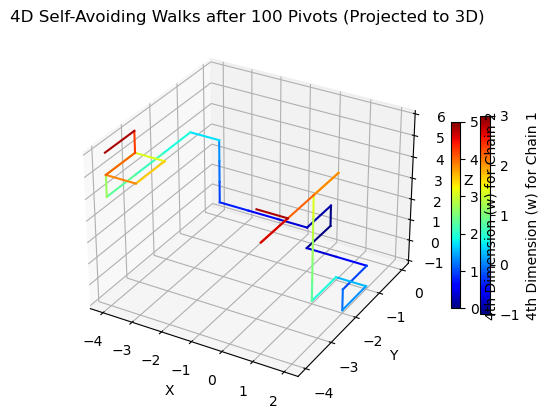

In [34]:
# Make 2 4D lattices and plot them in 3D projection
N = 27  # Number of monomers (number of steps)
l0 = 1  # Bond length (step length)
t = 100  # Number of pivot steps to perform

# Create instances of the LatticeSAW4D class
chain1 = LatticeSAW4D(N, l0)
chain1.walk(t)
chain2 = LatticeSAW4D(N, l0)
chain2.walk(t)

# Shift the first chain to the origin
chain1.state = chain1.shift_to_origin(chain1.state)
# Shift the second chain to (0, 0, 0, 1)
chain2.state = chain2.shift_to_origin_plus_one(chain2.state)

# Plot the walks after t pivots (projected to 3D)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors1 = plt.cm.jet(np.linspace(0, 1, len(chain1.state)))
colors2 = plt.cm.jet(np.linspace(0, 1, len(chain2.state)))

for i in range(N - 1):
    ax.plot(chain1.state[i:i+2, 0], chain1.state[i:i+2, 1], chain1.state[i:i+2, 2], color=colors1[i])
    ax.plot(chain2.state[i:i+2, 0], chain2.state[i:i+2, 1], chain2.state[i:i+2, 2], color=colors2[i])

# Add a color bar for the first chain
sm1 = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=np.min(chain1.state[:, 3]), vmax=np.max(chain1.state[:, 3])))
sm1.set_array([])
cbar1 = plt.colorbar(sm1, ax=ax, fraction=0.02, pad=0.04)
cbar1.set_label('4th Dimension (w) for Chain 1')

# Add a color bar for the second chain
sm2 = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=np.min(chain2.state[:, 3]), vmax=np.max(chain2.state[:, 3])))
sm2.set_array([])
cbar2 = plt.colorbar(sm2, ax=ax, fraction=0.02, pad=0.04)
cbar2.set_label('4th Dimension (w) for Chain 2')

ax.set_title(f'4D Self-Avoiding Walks after {t} Pivots (Projected to 3D)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [35]:

# Calculate the distance between two chains using cdist
distance = cdist(chain1.state, chain2.state)
distance = distance.flatten()
print(len(np.nonzero(distance)[0]) == len(distance))


True


In [41]:
N = 111  # Number of monomers (number of steps)
l0 = 1  # Bond length (step length)
t = 150  # Number of pivot steps to perform

# Parameters for estimation
num_samples = 1000  # Number of samples to estimate B_N

# Initialize the counter for B_N
B_n_counter = 0

# Loop over the number of samples
for i in range(num_samples):
    # Create an instance of the LatticeSAW4D class
    chain1 = LatticeSAW4D(N, l0)
    chain1.walk(t)
    
    chain2 = LatticeSAW4D(N, l0)
    chain2.walk(t)

    # Shift the first chain to the origin
    chain1.state = chain1.shift_to_origin(chain1.state)
    # Shift the second chain to the origin plus one
    chain2.state = chain2.shift_to_origin_plus_one(chain2.state)

    # Calculate the distance between two chains using cdist
    distance = cdist(chain1.state, chain2.state)
    distance = distance.flatten()

    # Check if the two chains are non-overlapping
    if len(np.nonzero(distance)[0]) == len(distance):
        B_n_counter += 1
    
# Calculate the average value of B_N
B_n_ave = B_n_counter / num_samples
print(f"Estimated B_N: {B_n_ave * 8}")

Estimated B_N: 5.488
